#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm

num_sims = 500
num_samples = 10
attack_size = 100
alpha = 0.05

rng = np.random.default_rng()

Then, define utility functions for simulating data and calculating the test statistics:


In [102]:
def synthesize(probs, n):
    return rng.binomial(n=1, p=probs, size = (n, len(probs)))


def test_homer(alice, sample_mean, population_mean):
    return sum(abs(alice - population_mean) - abs(alice - sample_mean))


def test_dwork(alice, sample_mean, population_mean):
    return sum((alice - population_mean) * (sample_mean - population_mean))


def null_distribution(test_stat, probs, population_mean, sims=1000, alpha=alpha):
    dist = []
    
    for _ in range(sims):
        samples = synthesize(probs, num_samples)
        sample_mean = np.zeros(len(probs))
        for i in range(num_samples):
            sample_mean += samples[i]
        sample_mean /= num_samples
        alice = synthesize(probs, 1)[0]
        dist.append(test_stat(alice, sample_mean, population_mean))
    
    dist.sort()
    dist.reverse()
    return dist, dist[round(alpha * sims)]
        

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

In [103]:
def plot_dist(x, crit_val):
    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x), max(x), num=1000)
    densities = kernel(support)
    
    flag = support < crit_val
    max_density = max(densities)
    
    plt.fill_between(support, densities, where=flag, color='blue')
    plt.fill_between(support, densities, where=~flag, color='red')
    
    plt.axvline(x=crit_val)
    
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()


Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

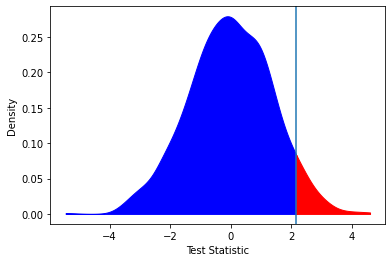

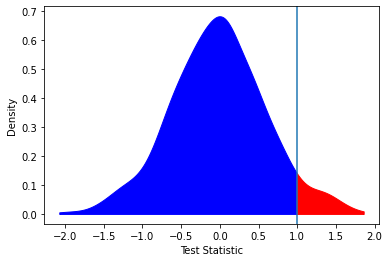

In [104]:
probs = np.random.uniform(size=attack_size)
population_mean = probs

# Homer Test
dist, crit_val = null_distribution(test_homer, probs, population_mean)
plot_dist(dist, crit_val)

# Dwork Test
dist, crit_val = null_distribution(test_dwork, probs, population_mean)
plot_dist(dist, crit_val)

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

Homer Alice: 


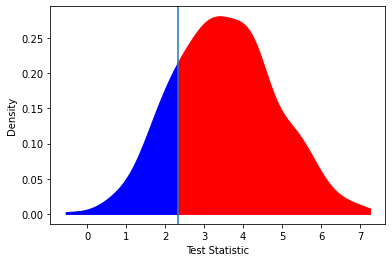

Homer Null: 


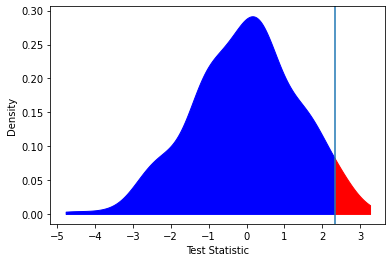

Dwork Alice: 


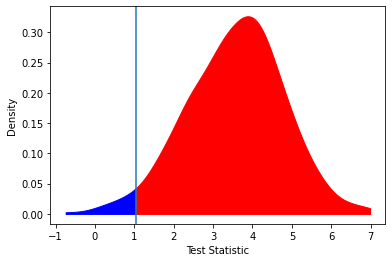

Dwork Null: 


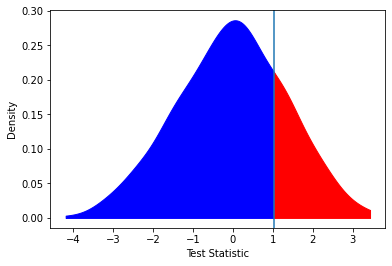

In [105]:
# Homer Test
dist, crit_val = null_distribution(test_homer, probs, population_mean, alpha=alpha)
alice_vals, null_vals = np.zeros(num_sims), np.zeros(num_sims)

for i in range(num_sims):
    samples = synthesize(probs, num_samples)
    sample_mean = np.zeros(len(probs))
    for j in range(num_samples):
        sample_mean += samples[j]
    sample_mean /= num_samples
    alice = samples[0]
    null_alice = synthesize(probs, 1)[0]

    alice_vals[i] = test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean) 
    null_vals[i] = test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)

print("Homer Alice: ")
plot_dist(alice_vals, crit_val)

print("Homer Null: ")
plot_dist(null_vals, crit_val)

# Dwork Test
dist, crit_val = null_distribution(test_dwork, probs, population_mean, alpha=alpha)
alice_vals, null_vals = np.zeros(num_sims), np.zeros(num_sims)

for i in range(num_sims):
    samples = synthesize(probs, num_samples)
    sample_mean = np.zeros(len(probs))
    for j in range(num_samples):
        sample_mean += samples[j]
    sample_mean /= num_samples
    alice = samples[0]
    null_alice = synthesize(probs, 1)[0]

    alice_vals[i] = test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean) 
    null_vals[i] = test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)

print("Dwork Alice: ")
plot_dist(alice_vals, crit_val)

print("Dwork Null: ")
plot_dist(null_vals, crit_val)

# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [106]:
def release_dp_mean(x, eps, lower, upper):
    scale = (upper - lower) / (len(x) * eps)
    avg = sum(np.clip(x, lower, upper)) / len(x)
    return avg + rng.laplace(0, scale)

Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [107]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")


In [108]:
# Visualize Data
print(data)
print('Min of educ: ', min(data['educ']))
print('Max of educ: ', max(data['educ']))

       state  puma  sex  age  educ    income  latino  black  asian  married  \
0         13  1101    1   51    11    2200.0       0      0      0        1   
1         13  1101    0   44    11  125030.0       0      0      0        1   
2         13  1101    0   60    11  105000.0       0      0      0        1   
3         13  1101    0   41    13   52000.0       0      0      0        0   
4         13  1101    0   56    13  263000.0       0      0      0        1   
...      ...   ...  ...  ...   ...       ...     ...    ...    ...      ...   
25761     13  1107    1   76     7    6000.0       0      1      0        0   
25762     13  1107    0   55     8   23200.0       0      1      0        1   
25763     13  1107    0   37    11   10000.0       0      1      0        0   
25764     13  1107    1   62    14   31000.0       0      1      0        0   
25765     13  1107    1   30     9   28000.0       0      1      0        0   

       divorced  uscitizen  children  disability  m

In [109]:
# Test the private mean release
print(release_dp_mean(data['educ'].values, eps=0.5, lower=1, upper=16))

10.608217509095807


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [110]:
def release_histogram(x, eps, categories):
    # We consider two histograms to be neighbours, if we can reach one from the other by changing
    # the category of at most one element, in which case we can see the maximum l1-norm between two
    # neighbouring histograms will be two
    sensitivity = 2
    scale = sensitivity / eps
    
    counts = {}
    for val in x:
        counts[val] = counts.get(val, 0) + 1
        
    histogram = np.zeros(len(categories))
    for i, category in enumerate(categories):
        hist[i] = counts.get(category, 0)
    
    return histogram + rng.laplace(0, scale, size=len(categories))


Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [138]:
def bootstrap(data, size):
    return data[rng.integers(0, len(data), size)]


size_vals = list(np.linspace(100, 200, 4)) + list(np.linspace(300, 500, 5)) + list(np.linspace(600, 1200, 7))
size_vals = [int(x) for x in size_vals]

eps_vals = list(np.linspace(0.1, 1, 5))

print(size_vals)
print(eps_vals)

results = []

for i in tqdm(range(len(size_vals))):
    size = size_vals[i]
    for eps in eps_vals:
        err = 0
        for _ in range(3*num_sims):
            sample = bootstrap(data['educ'].values, size)
            true_mean = sum(np.clip(sample, 1, 16)) / size
            private_mean = release_dp_mean(data['educ'].values, eps, 1, 16)
            err += (true_mean - private_mean) ** 2
            
        results.append({
            'size': size,
            'eps': eps,
            'error': err / num_sims,
        })




[100, 133, 166, 200, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 1100, 1200]
[0.1, 0.325, 0.55, 0.775, 1.0]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [06:51<00:00, 25.69s/it]


Now graph your resluts!

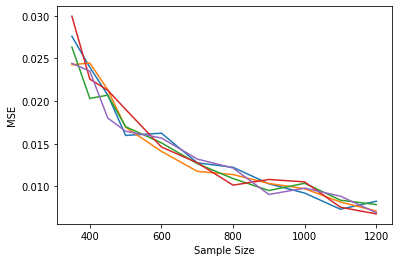

In [137]:
plt.ylabel("MSE")
plt.xlabel("Sample Size")

eps_res = {eps: [] for eps in eps_vals}
for record in results:
    eps = record['eps']
    eps_res[eps].append((record['size'], record['error']))

for eps in eps_vals:
    eps_res[eps].sort()
    xs, ys = [size for size, _ in eps_res[eps]], [err for _, err in eps_res[eps]]
    plt.plot(xs[5:], ys[5:])
            

plt.show()




---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [ ]:
# chain with the base_laplace measurement
dp_mean: Measurement = sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(arg=educ)

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [ ]:
# Check that when sensitivity is 0.15, the privacy usage is .30
base_laplace.check(d_in=.15, d_out=.30)

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [ ]:
help(make_count_by_categories)

In [ ]:
# release a histogram with laplace noise


In [ ]:
# release a histogram with geometric noise




---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [ ]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

And Finally Graph your result: